# CIFAR-10 с трюками

В этом задании мы продолжим работать с CIFAR-10, опробовав трюки, про которые мы узнали в 4 модуле.

Датасет CIFAR-10 состоит из цветных картинок 32x32, разделенных на 10 классов: 

__airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__

# Импорты

In [1]:
!pip install -q tensorflow==2.1

ERROR: Could not find a version that satisfies the requirement tensorflow==2.1 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0)
ERROR: No matching distribution found for tensorflow==2.1


In [6]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.12.0
2.12.0


# Загружаем данные

In [2]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [3]:
print("Трейн:", x_train.shape, y_train.shape)
print("Тест:", x_test.shape, y_test.shape)

Трейн: (50000, 32, 32, 3) (50000, 1)
Тест: (10000, 32, 32, 3) (10000, 1)


In [4]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

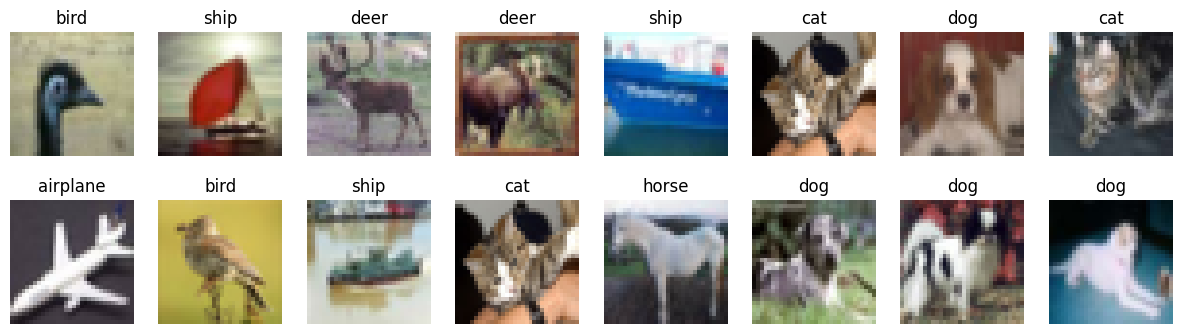

In [7]:
# посмотрим на примеры картинок
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Готовим данные

Не забудьте нормализовать картинки: $$x_{norm} = \frac{x}{255} - 0.5$$

А еще нужно превратить метки в one-hot вектора при помощи __keras.utils.to_categorical__.

In [8]:
# нормализуем входы
x_train2 = x_train.astype('float32') / 255 - 0.5
x_test2 = x_test.astype('float32') / 255 - 0.5

# конвертируем метки в np.array (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Задаем *дефолтную* архитектуру сети

In [9]:
# слои, которые нам пригодятся
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

Нам понадобятся такие слои:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - сверточный слой:
    - **filters**: количество фильтров на выходе; 
    - **kernel_size**: размер скользящего окна;
    - **padding**: padding="same" добивает нулями, чтобы ширина и высота на выходе не изменились, padding='valid' берет только окна, которые полностью помещаются в картинке;
    - **activation**: "relu", "tanh", итд;
    - **input_shape**: размер входа вида (W, H, C_in).
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - пулинг
- [Flatten](https://keras.io/layers/core/#flatten) - все оси, кроме батча (первой) вытягиваются в один вектор.
- [Dense](https://keras.io/layers/core/#dense) - плотный, активацию можно задать через activation="elu" или activation="softmax".
- [Dropout](https://keras.io/layers/core/#dropout) - дропаут регуляризация (без нее сеть сильно переобучается), позже узнаем какой у нее смысл.

Ваша модель должна принимать на вход цветную картинку __(None, 32, 32, 3)__ и предсказывать вероятности 10 классов __(None, 10)__.

Добавьте __4__ сверточных слоя с окном __(3, 3)__ с нарастающим количеством фильтров: __(16, 32, 32, 64)__, используйте "same" паддинг.

Добавьте __2x2__ макс пулинг после каждых 2 сверточных слоев (conv-conv-pool схема).

Используйте __activation='relu'__ для всех слоев, где это нужно.

Добавьте плотный слой из __256__ нейронов и еще один из __10__ нейронов для предсказания выходов. Не забудьте применить __Flatten__ перед первым плотным слоем!

Для регуляризации сети вставьте Dropout после каждого пулинг слоя (с параметром** 0.25**) и между плотными слоями на выходе (с параметром **0.5**).

В дальнейшем будем называть эту архитектуру **дефолтной** и будем исследовать небольшие изменения в ней!

In [11]:
img_shape = (32, 32, 3)
# num_classes = 10
def make_default_model():
    model = Sequential([
        keras.Input(shape = img_shape),
        keras.layers.Conv2D(16, (3, 3), activation = 'relu', padding='same'),
        keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding='same'),
        keras.layers.MaxPooling2D(),
        keras.layers.Dropout(0.25),
        keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding='same'),
        keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding='same'),
        keras.layers.MaxPooling2D(),
        keras.layers.Dropout(0.25),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation = 'relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation = 'softmax')
    ])
    
    return model

In [12]:
K.clear_session()
model = make_default_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        18496     
                                                        

# Тренируем модель

In [13]:
def train_model(make_model_func=make_default_model, optimizer="adam"):
  BATCH_SIZE = 32
  EPOCHS = 10

  K.clear_session()
  model = make_model_func()

  model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizer,
      metrics=['accuracy']
  )

  model.fit(
      x_train2, y_train2,  # нормализованные данные
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=(x_test2, y_test2),
      shuffle=False
  )
  
  return model

Давайте посмотрим, что будет с дефолтной моделью (модель = make_default_model, оптимайзер = "adam"), если ее немного поменять:


Часть 1 :
1.   Какое качество (accuracy) на валидации дает **дефолтная архитектура**?

Часть 2:
2.   Измените в дефолтной архитектуре **relu активацию на sigmoid**, какое качество на валидации получили?
3.   Измените в дефолтной архитектуре **adam оптимайзер на sgd**, какое качество на валидации получили?
4.   Добавьте к дефолтной архитектуре **батч нормализацию** после каждого сверточного слоя и после перового полносвязного (model.add(BatchNormalization())), какое качество на валидации получили?
5.   Добавьте к дефолтной архитектуре **батч нормализацию** и смените **relu активацию на sigmoid**,  какое качество на валидации получили?
  
*Рекомендуется завести свою функцию для каждого изменения архитектуры!*


In [14]:
# учим дефолтную архитектуру
train_model()

Epoch 1/10
1563/1563 [==============================] - 21s 6ms/step - loss: 1.4951 - accuracy: 0.4555 - val_loss: 1.0953 - val_accuracy: 0.6110
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1109 - accuracy: 0.6035 - val_loss: 0.8861 - val_accuracy: 0.6831
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9595 - accuracy: 0.6601 - val_loss: 0.8268 - val_accuracy: 0.7065
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8719 - accuracy: 0.6933 - val_loss: 0.7690 - val_accuracy: 0.7297
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8038 - accuracy: 0.7163 - val_loss: 0.7449 - val_accuracy: 0.7382
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7557 - accuracy: 0.7341 - val_loss: 0.7654 - val_accuracy: 0.7326
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7131 - accuracy: 0.7480 - val_loss: 0.7333 - val_accuracy

In [17]:
def make_sigmoid_model():
        model = Sequential([
        keras.Input(shape = img_shape),
        keras.layers.Conv2D(16, (3, 3), activation = 'sigmoid', padding='same'),
        keras.layers.Conv2D(32, (3, 3), activation = 'sigmoid', padding='same'),
        keras.layers.MaxPooling2D(),
        keras.layers.Dropout(0.25),
        keras.layers.Conv2D(32, (3, 3), activation = 'sigmoid', padding='same'),
        keras.layers.Conv2D(64, (3, 3), activation = 'sigmoid', padding='same'),
        keras.layers.MaxPooling2D(),
        keras.layers.Dropout(0.25),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation = 'sigmoid'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation = 'softmax')
        ])
    
        return model

In [18]:
# учим sigmoid
train_model(make_sigmoid_model)

Epoch 1/10
1563/1563 [==============================] - 12s 6ms/step - loss: 2.3163 - accuracy: 0.0972 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 2.3030 - accuracy: 0.0957 - val_loss: 2.3038 - val_accuracy: 0.1000
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 2.3065 - accuracy: 0.0978 - val_loss: 2.3059 - val_accuracy: 0.1000
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 2.3049 - accuracy: 0.0994 - val_loss: 2.3037 - val_accuracy: 0.1000
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 2.3048 - accuracy: 0.0974 - val_loss: 2.3036 - val_accuracy: 0.1000
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 2.3046 - accuracy: 0.0975 - val_loss: 2.3033 - val_accuracy: 0.1000
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 2.3045 - accuracy: 0.0984 - val_loss: 2.3035 - val_accuracy

In [19]:
# учим sgd
train_model(optimizer="sgd")

Epoch 1/10
1563/1563 [==============================] - 11s 6ms/step - loss: 2.0421 - accuracy: 0.2520 - val_loss: 1.7151 - val_accuracy: 0.3937
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.6682 - accuracy: 0.3927 - val_loss: 1.5064 - val_accuracy: 0.4538
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4999 - accuracy: 0.4559 - val_loss: 1.3300 - val_accuracy: 0.5180
Epoch 4/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.3806 - accuracy: 0.5022 - val_loss: 1.2510 - val_accuracy: 0.5515
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.2917 - accuracy: 0.5377 - val_loss: 1.1787 - val_accuracy: 0.5773
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2225 - accuracy: 0.5609 - val_loss: 1.0949 - val_accuracy: 0.6082
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1579 - accuracy: 0.5881 - val_loss: 1.0582 - val_accurac

In [20]:
def make_bn_model():
    model = Sequential([
        keras.Input(shape = img_shape),
        keras.layers.Conv2D(16, (3, 3), activation = 'relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(),
        keras.layers.Dropout(0.25),
        keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(),
        keras.layers.Dropout(0.25),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation = 'relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation = 'softmax')
    ])
    
    return model

In [21]:
# учим bn
train_model(make_bn_model)

Epoch 1/10
1563/1563 [==============================] - 16s 8ms/step - loss: 1.4547 - accuracy: 0.4980 - val_loss: 1.0123 - val_accuracy: 0.6390
Epoch 2/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0216 - accuracy: 0.6403 - val_loss: 0.8493 - val_accuracy: 0.7048
Epoch 3/10
1563/1563 [==============================] - 12s 7ms/step - loss: 0.8959 - accuracy: 0.6846 - val_loss: 0.7612 - val_accuracy: 0.7301
Epoch 4/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.8025 - accuracy: 0.7207 - val_loss: 0.6977 - val_accuracy: 0.7559
Epoch 5/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.7353 - accuracy: 0.7442 - val_loss: 0.6736 - val_accuracy: 0.7616
Epoch 6/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.6711 - accuracy: 0.7655 - val_loss: 0.6359 - val_accuracy: 0.7783
Epoch 7/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.6275 - accuracy: 0.7788 - val_loss: 0.6102 - val_ac

In [22]:
def make_sigmoid_bn_model():
    model = Sequential([
        keras.Input(shape = img_shape),
        keras.layers.Conv2D(16, (3, 3), activation = 'sigmoid', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(32, (3, 3), activation = 'sigmoid', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(),
        keras.layers.Dropout(0.25),
        keras.layers.Conv2D(32, (3, 3), activation = 'sigmoid', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, (3, 3), activation = 'sigmoid', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(),
        keras.layers.Dropout(0.25),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation = 'sigmoid'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation = 'softmax')
    ])
    
    return model

In [23]:
# учим sigmoid + bn
train_model(make_sigmoid_bn_model)

Epoch 1/10
1563/1563 [==============================] - 17s 8ms/step - loss: 1.6052 - accuracy: 0.4350 - val_loss: 1.2797 - val_accuracy: 0.5460
Epoch 2/10
1563/1563 [==============================] - 12s 7ms/step - loss: 1.2248 - accuracy: 0.5677 - val_loss: 1.1060 - val_accuracy: 0.6112
Epoch 3/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.1045 - accuracy: 0.6104 - val_loss: 1.0149 - val_accuracy: 0.6495
Epoch 4/10
1563/1563 [==============================] - 12s 7ms/step - loss: 1.0161 - accuracy: 0.6442 - val_loss: 0.9517 - val_accuracy: 0.6706
Epoch 5/10
1563/1563 [==============================] - 12s 7ms/step - loss: 0.9418 - accuracy: 0.6704 - val_loss: 0.8900 - val_accuracy: 0.6917
Epoch 6/10
1563/1563 [==============================] - 12s 7ms/step - loss: 0.8949 - accuracy: 0.6869 - val_loss: 0.8537 - val_accuracy: 0.7065
Epoch 7/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.8565 - accuracy: 0.7003 - val_loss: 0.8317 - val_ac